In [1]:
import src
import pandas as pd
import numpy as np
import os
from glob import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
import seaborn as sns

figure_path = src.figures_path / "tad_analysis"
os.makedirs(figure_path, exist_ok=True)

cleanup()

## TADs count and size for every cell type

In [2]:
def get_stats(datasets, grouping='cell_type'):
    """ Gathers some general statistics from a
    genomic dataset """
    
    stats = []

    for gname, tads in datasets.groupby(grouping):
        t_stats = {}

        # cell line
        t_stats[grouping] = gname

        # number
        t_n_tads = tads.shape[0]
        t_stats['n'] = t_n_tads

        t_sizes = tads.end - tads.start
        t_min_size = t_sizes.min()
        t_stats['min_size'] = t_min_size
        t_max_size = t_sizes.max()
        t_stats['max_size'] = t_max_size
        t_mean_size = t_sizes.mean()
        t_stats['mean_size'] = t_mean_size
        t_std_size = t_sizes.std()
        t_stats['std_size'] = t_std_size

        stats.append(t_stats)

    stats = pd.DataFrame.from_dict(stats)[[grouping, 'n',
                                          'min_size', 'max_size', 'mean_size', 'std_size']]
    return stats

    
def plot_sizes(datasets, grouping='cell_type', ax=None):
    """ Plots the region size distribution of a 
    genomic dataset """
    
    tad_sizes = {}
    for cell_line, tads in datasets.groupby(grouping):
        t_sizes = tads.end - tads.start
        tad_sizes[cell_line] = t_sizes
    tad_sizes = pd.DataFrame.from_dict(tad_sizes)
    sns.boxplot(data=tad_sizes, orient="v", showfliers=False, order=sorted(tad_sizes.columns), ax=ax)

In [3]:
tads_path = src.processed_data_path / "TAD_definitions"

In [4]:
all_tads = []
for f in glob(str(tads_path / "*.tsv")):
    df = pd.read_csv(tads_path / f, sep="\t").sort_values(src.coords)
    cell_type = f.split("/")[-1].split("_")[1]
    df['tad_number'] = df.index
    df['cell_type'] = cell_type
    df['tad_uid'] = cell_type + "_" + df.index.map(lambda x: "{:04d}".format(x))
    all_tads.append(df)
all_tads = pd.concat(all_tads, axis=0)
all_tads = all_tads.sort_values(src.coords).reset_index(drop=True)
all_tads.head()

,chr,start,end,tad_number,cell_type,tad_uid
0,chr1,1612500,1847500,0,Mon,Mon_0000
1,chr1,1646875,1842500,0,nB,nB_0000
2,chr1,1847500,2345000,0,Ery,Ery_0000
3,chr1,1979375,2665000,0,Neu,Neu_0000
4,chr1,2112500,2342500,1,nB,nB_0001


#### We do not consider Neutrophils

In [5]:
all_tads = all_tads[all_tads.cell_type != 'Neu'].reset_index(drop=True)

In [6]:
all_tads.to_csv(src.interim_data_path / "all_TADs_by_celltype.tsv", sep='\t', index=False, header=True)

### TAD size and number of TADs

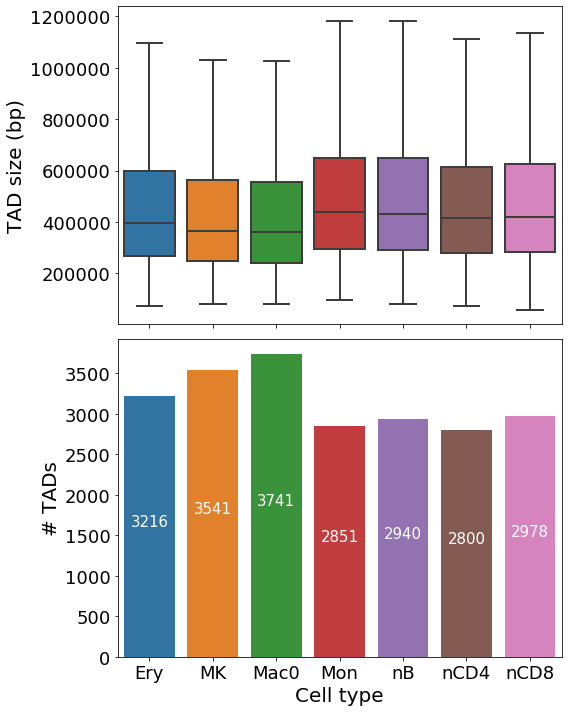

In [7]:
tad_stats = get_stats(all_tads)

fig, axes = plt.subplots(2,1,sharex=True, figsize=(8, 10))
plot_sizes(all_tads, ax=axes[0])
axes[0].set_ylabel("TAD size (bp)", fontsize=20)

ax = sns.countplot(all_tads['cell_type'], order=sorted(all_tads.cell_type.unique()), ax=axes[1])
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), ((p.get_x() + p.get_width()/2), p.get_height()/2),color='white',horizontalalignment='center', fontsize=15)
plt.xlabel("Cell type", fontsize=20)
axes[1].set_ylabel("# TADs", fontsize=20)
fig.savefig(figure_path / "TADs_stats_by_celltype.pdf", bbox_inches='tight', transparent=True)
plt.show()

### TAD size distribution

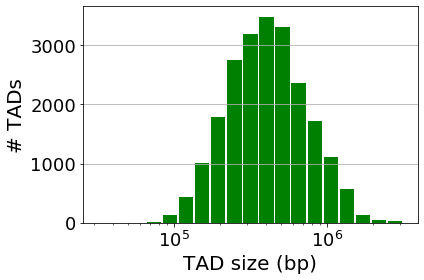

In [8]:
fig = plt.figure()
bls = (all_tads.end - all_tads.start).values
plt.hist(bls, bins=np.logspace(4.5, 6.5, 20), color='g', rwidth=0.9)
plt.xscale("log")
plt.xlabel('TAD size (bp)', fontsize=20)
plt.ylabel('# TADs', fontsize=20)
plt.grid(axis='y')
fig.savefig(figure_path / "TADs_size_distribution.pdf", bbox_inches='tight', transparent=True)
fig.show()

### TAD size distribution by cell type

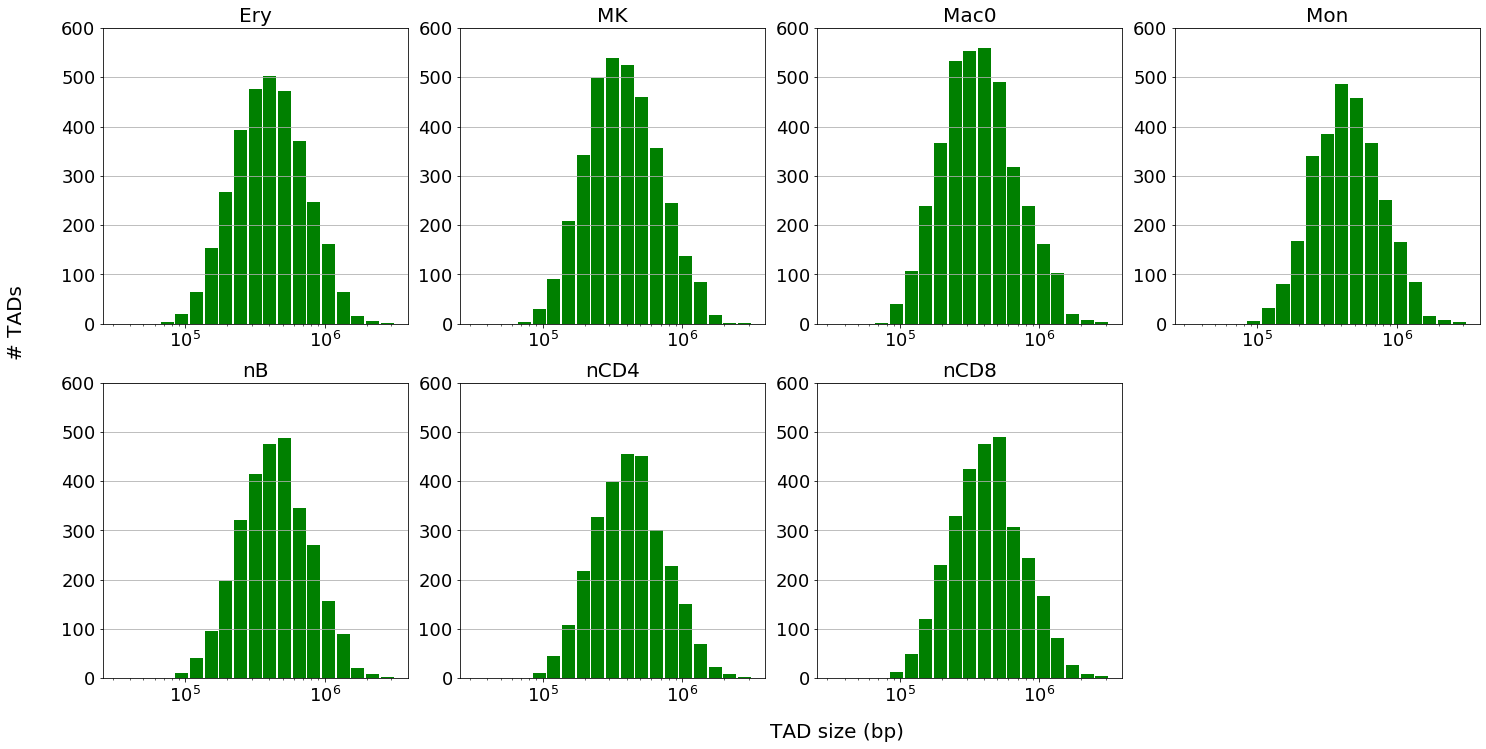

In [9]:
fig = plt.figure(figsize=(20, 10))

i = 1
for tn in sorted(all_tads.cell_type.unique()):
    plt.subplot(2, 4, i)
    data = all_tads[all_tads.cell_type == tn]
    bls = (data.end - data.start).values
    plt.hist(bls, bins=np.logspace(4.5, 6.5, 20), color='g', rwidth=0.9)
    plt.xscale("log")
#     plt.xlabel('TAD size (bp)', fontsize=14)
    plt.title(tn, fontsize=20)
    plt.grid(axis='y')
    plt.ylim(0, 600)
    i += 1
plt.tight_layout()
fig.text(0.5, -0.03, "TAD size (bp)", fontsize=20)
fig.text(-0.03, 0.5, "# TADs", fontsize=20, rotation=90)
fig.savefig(figure_path / "TADs_size_distribution_by_celltype.pdf", bbox_inches='tight', transparent=True)
plt.show()

### Inter-TADs size distribution

In [10]:
def complement(tads):
    return BedTool.from_dataframe(tads).complement(genome='hg19').sort().to_dataframe(names=tads.columns)

In [11]:
all_interTADs = []
for tn in sorted(all_tads.cell_type.unique()):
    tn_complement = complement(all_tads.loc[all_tads.cell_type == tn, src.coords])
    tn_complement['tad_number'] = tn_complement.index
    tn_complement['cell_type'] = tn
    tn_complement['tad_uid'] = tn + "_" + tn_complement.index.map(lambda x: "{:04d}".format(x))
    all_interTADs.append(tn_complement)
all_interTADs = pd.concat(all_interTADs, axis=0).sort_values(src.coords).reset_index(drop=True)
all_interTADs.head()

,chr,start,end,tad_number,cell_type,tad_uid
0,chr1,0,1612500,0,Mon,Mon_0000
1,chr1,0,1646875,0,nB,nB_0000
2,chr1,0,1847500,0,Ery,Ery_0000
3,chr1,0,2112500,0,Mac0,Mac0_0000
4,chr1,0,2350000,0,nCD8,nCD8_0000


In [12]:
all_interTADs.to_csv(src.interim_data_path / "all_interTADs_by_celltype.tsv", sep='\t', index=False, header=True)

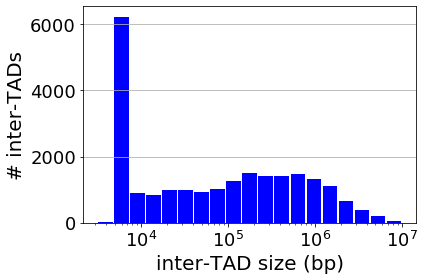

In [13]:
fig = plt.figure()
bls = (all_interTADs.end - all_interTADs.start).values
plt.hist(bls, bins=np.logspace(3.5, 7, 20), color='blue', rwidth=0.9)
plt.xscale("log")
plt.xlabel('inter-TAD size (bp)', fontsize=20)
plt.ylabel('# inter-TADs', fontsize=20)
plt.grid(axis='y')
fig.savefig(figure_path / "interTADs_size_distribution.pdf", bbox_inches='tight', transparent=True)
fig.show()

### Inter-TADs size distribution by cell type

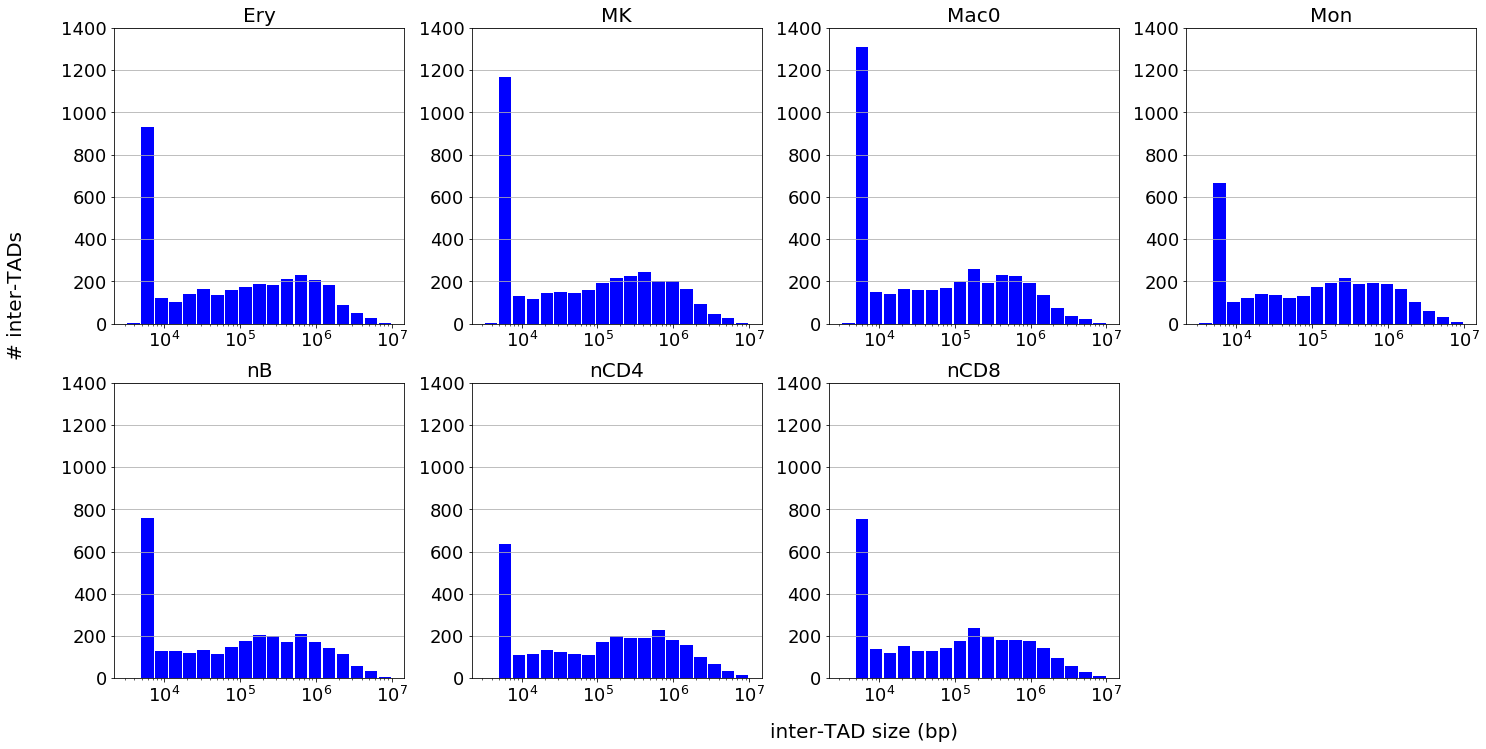

In [14]:
fig = plt.figure(figsize=(20, 10))

i = 1
for tn in sorted(all_interTADs.cell_type.unique()):
    plt.subplot(2, 4, i)
    data = all_interTADs[all_interTADs.cell_type == tn]
    bls = (data.end - data.start).values
    plt.hist(bls, bins=np.logspace(3.5, 7, 20), color='blue', rwidth=0.9)
    plt.xscale("log")
#     plt.xlabel('TAD size (bp)', fontsize=14)
    plt.title(tn, fontsize=20)
    plt.grid(axis='y')
    plt.ylim(0, 1400)
    i += 1
plt.tight_layout()
fig.text(0.5, -0.03, "inter-TAD size (bp)", fontsize=20)
fig.text(-0.03, 0.5, "# inter-TADs", fontsize=20, rotation=90)
fig.savefig(figure_path / "interTADs_size_distribution_by_celltype.pdf", bbox_inches='tight', transparent=True)
plt.show()